<center>
    <img src="images/personal_logo.png"/>
</center>

# Deep Unsupervised Learning - Final Project
### Juan Carlos Garzon Pico
### Viviane Alves

---

<br>

<div align="center">
  
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/Juank0621)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?logo=linkedin)](https://www.linkedin.com/in/juancarlosgarzon)
![Python](https://badges.aleen42.com/src/python.svg)

</div>

### CIFAR10 AI System

We are developing an AI system using deep learning techniques like Convolutional Autoencoders (CAE), Variational Autoencoders (VAE), and Generative Adversarial Networks (GANs) with the CIFAR10 dataset. These models will help in facial feature extraction, attribute classification, and image generation. By leveraging these approaches, we aim to enhance face recognition, noise reduction, and synthetic face generation for improved image analysis.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from PIL import Image
from tqdm import tqdm   
#from tqdm.rich import tqdm  # Import tqdm.rich for progress bars

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision.models import resnet18  # Import ResNet18
from torchsummary import summary

torch.set_float32_matmul_precision('medium')

## PyTorch and GPU Information

This code snippet displays the PyTorch version, CUDA version, cuDNN version, and the number of GPUs available for PyTorch.

The first line prints the PyTorch version being used.
The second and third lines retrieve and display the CUDA and cuDNN versions used by PyTorch.
The final line shows the number of GPUs available for PyTorch, helping to confirm whether your system is utilizing the GPU for processing.
This is useful for ensuring that your environment is correctly set up to use GPU acceleration.

In [2]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.6.0+cu124


In [3]:
# Get the CUDA version used by PyTorch
cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)

# Get the cuDNN version used by PyTorch
cudnn_version = torch.backends.cudnn.version()
print("cuDNN Version:", cudnn_version)

CUDA Version: 12.4
cuDNN Version: 90100


In [4]:
# Get the number of GPUs available
num_gpus = torch.cuda.device_count()
print("Num GPUs Available:", num_gpus)

Num GPUs Available: 1


Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [5]:
!nvidia-smi

Fri Apr  4 09:08:59 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
| 30%   27C    P8              10W / 320W |    462MiB / 16376MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset Directory

Here we define the transformations to be applied to the images in the CIFAR10 dataset.

In [6]:
# Define transformations for the CIFAR10 dataset
# We normalize the images to have a mean of 0.5 and a standard deviation of 0.5 for each channel.
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
kwargs = {'num_workers': 8, 'pin_memory': True} # DataLoader optimization for better performance on CUDA.

In [8]:
dummy_dataset = CIFAR10(root='./data', train=True, download=True)
print(dummy_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# Custom dataset class to filter CIFAR10 images by a specific class.
class OneClassDatasetCIFAR10(CIFAR10):
    def __init__(self, root_dir, real_class=1, transform=None, train=True, download=True):
        super().__init__(root=root_dir, transform=transform, train=train, download=download)
        self.real_class = real_class
        self.samples = []
        for i in range(len(self.data)):
            if self.targets[i] == self.real_class:
                self.samples.append((self.data[i], self.targets[i]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = self.samples[idx]
        image = Image.fromarray(data[0])  # Convertir a objeto PIL

        # Aplicar transformaciones si están definidas
        if self.transform:
            image = self.transform(image)

        label = 0  # Dummy label as autoencoder does not need labels

        return image, label

## Variational autoencoder (VAE)

Encoder for the VAE using convolutional layers. It reduces the spatial dimensions of the input image while increasing the number of feature maps, eventually flattening the output for the latent space.

In [10]:
# Encoder for the VAE using ResNet18 architecture
class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE_Encoder, self).__init__()
        # Load ResNet18 without pre-trained weights
        resnet = resnet18(weights=None)
        # Remove the fully connected layer (fc) to use it as a feature extractor
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove the last fc layer
        self.flatten = nn.Flatten()  # Flatten the output of the feature extractor
        self.fc_mean = nn.Linear(512, latent_dim)  # Map to latent space (mean)
        self.fc_logvar = nn.Linear(512, latent_dim)  # Map to latent space (log variance)

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features
        x = self.flatten(x)  # Flatten the features
        mean = self.fc_mean(x)  # Compute mean
        logvar = self.fc_logvar(x)  # Compute log variance
        return mean, logvar

Decoder for the VAE using transposed convolutional layers. It reconstructs the image from the latent space back to the original 32x32 resolution with 3 channels.

In [11]:
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE_Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 1024)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 2, 2)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 2x2 → 4x4
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 4x4 → 8x8
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 8x8 → 16x16
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # 16x16 → 32x32
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, z):
        x = self.fc(z)
        x = self.decoder(x)
        return x

Variational Autoencoder (VAE) combining the encoder and decoder. It includes the reparameterization trick to sample from the latent space.

In [12]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder = VAE_Encoder(latent_dim)
        self.decoder = VAE_Decoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decoder(z)
        return x_hat, mean, logvar

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
def vae_loss_function(x, x_hat, mean, log_var, beta=0.1):
    reconstruction_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')  # Changed to 'mean'
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    kl_divergence = torch.clamp(kl_divergence, min=-1e6, max=1e6)
    return reconstruction_loss + beta * kl_divergence / x.size(0)  # Normalize KL by batch size

# Function to train the VAE for one epoch with tqdm
def train_vae_epoch(vae, train_loader, optimizer):
    vae.train()
    total_loss = 0
    # Use standard tqdm to display progress
    for inputs, _ in tqdm(train_loader, desc="Training VAE Epoch", leave=False):
        # Remove the line that flattens the inputs
        inputs = inputs.to(device)  # Keep inputs in 4D format (batch_size, channels, height, width)
        inputs = torch.clamp(inputs, 0., 1.)  # Normalize inputs to range [0, 1]
        optimizer.zero_grad()
        x_hat, mean, log_var = vae(inputs)
        loss = vae_loss_function(inputs, x_hat, mean, log_var, beta=0.1)
        if torch.isnan(loss):
            print("NaN detected in loss! Skipping batch.")
            continue
        loss.backward()

        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Update evaluate_vae to avoid flattening inputs
def evaluate_vae(vae, val_loader):
    vae.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)  # Keep inputs in 4D format
            x_hat, mean, log_var = vae(inputs)
            loss = vae_loss_function(inputs, x_hat, mean, log_var)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Update test_vae to avoid flattening inputs
def test_vae(vae, test_loader, threshold):
    vae.eval()
    anomalies = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)  # Keep inputs in 4D format
            x_hat, mean, log_var = vae(inputs)
            z = vae.reparameterize(mean, log_var)
            distances = [calculate_mahalanobis_distance(mean[i], torch.eye(mean.size(1)).to(device), z[i]) for i in range(z.size(0))]
            anomalies.extend([d > threshold for d in distances])
    return anomalies

def calculate_mahalanobis_distance(mean, covariance, x):
    diff = x - mean
    inv_covariance = torch.linalg.inv(covariance)
    distance = torch.sqrt(torch.mm(torch.mm(diff.unsqueeze(0), inv_covariance), diff.unsqueeze(1)))
    return distance.item()


In [15]:
# Update main_vae to use the CNN-based VAE
def main_vae():
    latent_dim = 128
    num_epochs = 30
    learning_rate = 1e-4

    vae = VAE(latent_dim).to(device)  # Use VAE

    # Display the architecture of the model
    summary(vae, input_size=(3, 32, 32))  # Input size matches CIFAR10 images
    
    optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

    all_train_losses = []
    all_val_losses = []

    for real_class in range(10):
        print(f"Training VAE for class {real_class}...")

        train_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=True, download=True)
        val_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=False, download=True)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, **kwargs)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, **kwargs)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            train_loss = train_vae_epoch(vae, train_loader, optimizer)
            val_loss = evaluate_vae(vae, val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Save the trained model
        torch.save(vae.state_dict(), f'models/vae/vae_class_{real_class}_weights.pth')

    return all_train_losses, all_val_losses

In [16]:
# Call the main function for VAE
all_train_losses, all_val_losses = main_vae()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Epoch 1/30, Train Loss: 1.1987, Val Loss: 0.4404


Epoch 2/30, Train Loss: 0.1253, Val Loss: 0.3089


Epoch 3/30, Train Loss: 0.1098, Val Loss: 0.2866


Epoch 4/30, Train Loss: 0.1037, Val Loss: 0.2760


Epoch 5/30, Train Loss: 0.1013, Val Loss: 0.2694


Epoch 6/30, Train Loss: 0.1005, Val Loss: 0.2661


Epoch 7/30, Train Loss: 0.0999, Val Loss: 0.2625


Epoch 8/30, Train Loss: 0.0997, Val Loss: 0.2616


Epoch 9/30, Train Loss: 0.0994, Val Loss: 0.2620


Epoch 10/30, Train Loss: 0.0991, Val Loss: 0.2599


Epoch 11/30, Train Loss: 0.0989, Val Loss: 0.2610


Epoch 12/30, Train Loss: 0.0989, Val Loss: 0.2600


Epoch 13/30, Train Loss: 0.0989, Val Loss: 0.2604


Epoch 14/30, Train Loss: 0.0992, Val Loss: 0.2591


Epoch 15/30, Train Loss: 0.0986, Val Loss: 0.2588


Epoch 16/30, Train Loss: 0.0987, Val Loss: 0.2592


Epoch 17/30, Train Loss: 0.0985, Val Loss: 0.2587


Epoch 18/30, Train Loss: 0.0990, Val Loss: 0.2581


Epoch 19/30, Train Loss: 0.0990, Val Loss: 0.2580


Epoch 20/30, Train Loss: 0.0986, Val Loss: 0.2590


Epoch 21/30, Train Loss: 0.0984, Val Loss: 0.2585


Epoch 22/30, Train Loss: 0.0986, Val Loss: 0.2592


Epoch 23/30, Train Loss: 0.0987, Val Loss: 0.2579


Epoch 24/30, Train Loss: 0.0986, Val Loss: 0.2588


Epoch 25/30, Train Loss: 0.0983, Val Loss: 0.2585


Epoch 26/30, Train Loss: 0.0984, Val Loss: 0.2591


Epoch 27/30, Train Loss: 0.0981, Val Loss: 0.2590


Epoch 28/30, Train Loss: 0.0987, Val Loss: 0.2587


Epoch 29/30, Train Loss: 0.0987, Val Loss: 0.2586


Epoch 30/30, Train Loss: 0.0983, Val Loss: 0.2588
Training VAE for class 1...


Epoch 1/30, Train Loss: 0.0910, Val Loss: 0.3723


Epoch 2/30, Train Loss: 0.0869, Val Loss: 0.3633


Epoch 3/30, Train Loss: 0.0861, Val Loss: 0.3633


Epoch 4/30, Train Loss: 0.0862, Val Loss: 0.3598


Epoch 5/30, Train Loss: 0.0861, Val Loss: 0.3603


Epoch 6/30, Train Loss: 0.0861, Val Loss: 0.3592


Epoch 7/30, Train Loss: 0.0866, Val Loss: 0.3584


Epoch 8/30, Train Loss: 0.0865, Val Loss: 0.3587


Epoch 9/30, Train Loss: 0.0859, Val Loss: 0.3606


Epoch 10/30, Train Loss: 0.0859, Val Loss: 0.3591


Epoch 11/30, Train Loss: 0.0859, Val Loss: 0.3607


Epoch 12/30, Train Loss: 0.0861, Val Loss: 0.3584


Epoch 13/30, Train Loss: 0.0862, Val Loss: 0.3592


Epoch 14/30, Train Loss: 0.0864, Val Loss: 0.3573


Epoch 15/30, Train Loss: 0.0859, Val Loss: 0.3588


Epoch 16/30, Train Loss: 0.0861, Val Loss: 0.3585


Epoch 17/30, Train Loss: 0.0867, Val Loss: 0.3571


Epoch 18/30, Train Loss: 0.0860, Val Loss: 0.3589


Epoch 19/30, Train Loss: 0.0861, Val Loss: 0.3578


Epoch 20/30, Train Loss: 0.0857, Val Loss: 0.3585


Epoch 21/30, Train Loss: 0.0861, Val Loss: 0.3601


Epoch 22/30, Train Loss: 0.0860, Val Loss: 0.3584


Epoch 23/30, Train Loss: 0.0858, Val Loss: 0.3594


Epoch 24/30, Train Loss: 0.0867, Val Loss: 0.3576


Epoch 25/30, Train Loss: 0.0858, Val Loss: 0.3583


Epoch 26/30, Train Loss: 0.0859, Val Loss: 0.3588


Epoch 27/30, Train Loss: 0.0860, Val Loss: 0.3572


Epoch 28/30, Train Loss: 0.0858, Val Loss: 0.3573


Epoch 29/30, Train Loss: 0.0859, Val Loss: 0.3585


Epoch 30/30, Train Loss: 0.0862, Val Loss: 0.3577
Training VAE for class 2...


Epoch 1/30, Train Loss: 0.0671, Val Loss: 0.2679


Epoch 2/30, Train Loss: 0.0666, Val Loss: 0.2662


Epoch 3/30, Train Loss: 0.0661, Val Loss: 0.2651


Epoch 4/30, Train Loss: 0.0661, Val Loss: 0.2654


Epoch 5/30, Train Loss: 0.0659, Val Loss: 0.2658


Epoch 6/30, Train Loss: 0.0664, Val Loss: 0.2654


Epoch 7/30, Train Loss: 0.0664, Val Loss: 0.2649


Epoch 8/30, Train Loss: 0.0663, Val Loss: 0.2648


Epoch 9/30, Train Loss: 0.0661, Val Loss: 0.2645


Epoch 10/30, Train Loss: 0.0665, Val Loss: 0.2655


Epoch 11/30, Train Loss: 0.0660, Val Loss: 0.2662


Epoch 12/30, Train Loss: 0.0661, Val Loss: 0.2656


Epoch 13/30, Train Loss: 0.0660, Val Loss: 0.2659


Epoch 14/30, Train Loss: 0.0658, Val Loss: 0.2670


Epoch 15/30, Train Loss: 0.0662, Val Loss: 0.2644


Epoch 16/30, Train Loss: 0.0660, Val Loss: 0.2652


Epoch 17/30, Train Loss: 0.0664, Val Loss: 0.2651


Epoch 18/30, Train Loss: 0.0659, Val Loss: 0.2666


Epoch 19/30, Train Loss: 0.0659, Val Loss: 0.2646


Epoch 20/30, Train Loss: 0.0658, Val Loss: 0.2647


Epoch 21/30, Train Loss: 0.0658, Val Loss: 0.2655


Epoch 22/30, Train Loss: 0.0658, Val Loss: 0.2657


Epoch 23/30, Train Loss: 0.0660, Val Loss: 0.2647


Epoch 24/30, Train Loss: 0.0666, Val Loss: 0.2652


Epoch 25/30, Train Loss: 0.0662, Val Loss: 0.2652


Epoch 26/30, Train Loss: 0.0659, Val Loss: 0.2651


Epoch 27/30, Train Loss: 0.0658, Val Loss: 0.2656


Epoch 28/30, Train Loss: 0.0667, Val Loss: 0.2647


Epoch 29/30, Train Loss: 0.0667, Val Loss: 0.2656


Epoch 30/30, Train Loss: 0.0660, Val Loss: 0.2649
Training VAE for class 3...


Epoch 1/30, Train Loss: 0.0770, Val Loss: 0.3301


Epoch 2/30, Train Loss: 0.0773, Val Loss: 0.3283


Epoch 3/30, Train Loss: 0.0767, Val Loss: 0.3288


Epoch 4/30, Train Loss: 0.0766, Val Loss: 0.3302


Epoch 5/30, Train Loss: 0.0767, Val Loss: 0.3288


Epoch 6/30, Train Loss: 0.0767, Val Loss: 0.3282


Epoch 7/30, Train Loss: 0.0771, Val Loss: 0.3288


Epoch 8/30, Train Loss: 0.0764, Val Loss: 0.3311


Epoch 9/30, Train Loss: 0.0766, Val Loss: 0.3325


Epoch 10/30, Train Loss: 0.0764, Val Loss: 0.3293


Epoch 11/30, Train Loss: 0.0765, Val Loss: 0.3295


Epoch 12/30, Train Loss: 0.0766, Val Loss: 0.3289


Epoch 13/30, Train Loss: 0.0767, Val Loss: 0.3309


Epoch 14/30, Train Loss: 0.0766, Val Loss: 0.3285


Epoch 15/30, Train Loss: 0.0767, Val Loss: 0.3292


Epoch 16/30, Train Loss: 0.0768, Val Loss: 0.3288


Epoch 17/30, Train Loss: 0.0766, Val Loss: 0.3292


Epoch 18/30, Train Loss: 0.0776, Val Loss: 0.3280


Epoch 19/30, Train Loss: 0.0765, Val Loss: 0.3318


Epoch 20/30, Train Loss: 0.0770, Val Loss: 0.3304


Epoch 21/30, Train Loss: 0.0764, Val Loss: 0.3294


Epoch 22/30, Train Loss: 0.0776, Val Loss: 0.3285


Epoch 23/30, Train Loss: 0.0772, Val Loss: 0.3290


Epoch 24/30, Train Loss: 0.0764, Val Loss: 0.3289


Epoch 25/30, Train Loss: 0.0767, Val Loss: 0.3305


Epoch 26/30, Train Loss: 0.0767, Val Loss: 0.3288


Epoch 27/30, Train Loss: 0.0773, Val Loss: 0.3291


Epoch 28/30, Train Loss: 0.0764, Val Loss: 0.3333


Epoch 29/30, Train Loss: 0.0764, Val Loss: 0.3281


Epoch 30/30, Train Loss: 0.0769, Val Loss: 0.3297
Training VAE for class 4...


Epoch 1/30, Train Loss: 0.0512, Val Loss: 0.2461


Epoch 2/30, Train Loss: 0.0498, Val Loss: 0.2432


Epoch 3/30, Train Loss: 0.0495, Val Loss: 0.2420


Epoch 4/30, Train Loss: 0.0497, Val Loss: 0.2428


Epoch 5/30, Train Loss: 0.0501, Val Loss: 0.2415


Epoch 6/30, Train Loss: 0.0497, Val Loss: 0.2415


Epoch 7/30, Train Loss: 0.0498, Val Loss: 0.2412


Epoch 8/30, Train Loss: 0.0500, Val Loss: 0.2419


Epoch 9/30, Train Loss: 0.0497, Val Loss: 0.2420


Epoch 10/30, Train Loss: 0.0498, Val Loss: 0.2417


Epoch 11/30, Train Loss: 0.0494, Val Loss: 0.2416


Epoch 12/30, Train Loss: 0.0497, Val Loss: 0.2413


Epoch 13/30, Train Loss: 0.0496, Val Loss: 0.2454


Epoch 14/30, Train Loss: 0.0499, Val Loss: 0.2447


Epoch 15/30, Train Loss: 0.0497, Val Loss: 0.2434


Epoch 16/30, Train Loss: 0.0499, Val Loss: 0.2475


Epoch 17/30, Train Loss: 0.0494, Val Loss: 0.2542


Epoch 18/30, Train Loss: 0.0495, Val Loss: 0.2414


Epoch 19/30, Train Loss: 0.0500, Val Loss: 0.2415


Epoch 20/30, Train Loss: 0.0499, Val Loss: 0.2414


Epoch 21/30, Train Loss: 0.0495, Val Loss: 0.2420


Epoch 22/30, Train Loss: 0.0496, Val Loss: 0.2424


Epoch 23/30, Train Loss: 0.0496, Val Loss: 0.2420


Epoch 24/30, Train Loss: 0.0495, Val Loss: 0.2422


Epoch 25/30, Train Loss: 0.0496, Val Loss: 0.2416


Epoch 26/30, Train Loss: 0.0497, Val Loss: 0.2422


Epoch 27/30, Train Loss: 0.0496, Val Loss: 0.2411


Epoch 28/30, Train Loss: 0.0495, Val Loss: 0.2410


Epoch 29/30, Train Loss: 0.0496, Val Loss: 0.2422


Epoch 30/30, Train Loss: 0.0500, Val Loss: 0.2420
Training VAE for class 5...


Epoch 1/30, Train Loss: 0.0715, Val Loss: 0.3019


Epoch 2/30, Train Loss: 0.0708, Val Loss: 0.3055


Epoch 3/30, Train Loss: 0.0714, Val Loss: 0.3029


Epoch 4/30, Train Loss: 0.0709, Val Loss: 0.3039


Epoch 5/30, Train Loss: 0.0708, Val Loss: 0.3051


Epoch 6/30, Train Loss: 0.0709, Val Loss: 0.3046


Epoch 7/30, Train Loss: 0.0707, Val Loss: 0.3051


Epoch 8/30, Train Loss: 0.0707, Val Loss: 0.3043


Epoch 9/30, Train Loss: 0.0706, Val Loss: 0.3038


Epoch 10/30, Train Loss: 0.0709, Val Loss: 0.3043


Epoch 11/30, Train Loss: 0.0706, Val Loss: 0.3043


Epoch 12/30, Train Loss: 0.0706, Val Loss: 0.3047


Epoch 13/30, Train Loss: 0.0711, Val Loss: 0.3043


Epoch 14/30, Train Loss: 0.0706, Val Loss: 0.3042


Epoch 15/30, Train Loss: 0.0706, Val Loss: 0.3034


Epoch 16/30, Train Loss: 0.0706, Val Loss: 0.3044


Epoch 17/30, Train Loss: 0.0711, Val Loss: 0.3044


Epoch 18/30, Train Loss: 0.0708, Val Loss: 0.3079


Epoch 19/30, Train Loss: 0.0711, Val Loss: 0.3030


Epoch 20/30, Train Loss: 0.0708, Val Loss: 0.3037


Epoch 21/30, Train Loss: 0.0706, Val Loss: 0.3056


Epoch 22/30, Train Loss: 0.0709, Val Loss: 0.3063


Epoch 23/30, Train Loss: 0.0706, Val Loss: 0.3032


Epoch 24/30, Train Loss: 0.0708, Val Loss: 0.3042


Epoch 25/30, Train Loss: 0.0706, Val Loss: 0.3050


Epoch 26/30, Train Loss: 0.0710, Val Loss: 0.3110


Epoch 27/30, Train Loss: 0.0709, Val Loss: 0.3048


Epoch 28/30, Train Loss: 0.0708, Val Loss: 0.3052


Epoch 29/30, Train Loss: 0.0708, Val Loss: 0.3042


Epoch 30/30, Train Loss: 0.0707, Val Loss: 0.3049
Training VAE for class 6...


Epoch 1/30, Train Loss: 0.0529, Val Loss: 0.2897


Epoch 2/30, Train Loss: 0.0520, Val Loss: 0.2855


Epoch 3/30, Train Loss: 0.0518, Val Loss: 0.2849


Epoch 4/30, Train Loss: 0.0525, Val Loss: 0.2832


Epoch 5/30, Train Loss: 0.0523, Val Loss: 0.2836


Epoch 6/30, Train Loss: 0.0519, Val Loss: 0.2840


Epoch 7/30, Train Loss: 0.0517, Val Loss: 0.2929


Epoch 8/30, Train Loss: 0.0526, Val Loss: 0.2834


Epoch 9/30, Train Loss: 0.0519, Val Loss: 0.2840


Epoch 10/30, Train Loss: 0.0521, Val Loss: 0.2835


Epoch 11/30, Train Loss: 0.0516, Val Loss: 0.2834


Epoch 12/30, Train Loss: 0.0517, Val Loss: 0.2843


Epoch 13/30, Train Loss: 0.0516, Val Loss: 0.2850


Epoch 14/30, Train Loss: 0.0518, Val Loss: 0.2836


Epoch 15/30, Train Loss: 0.0518, Val Loss: 0.2842


Epoch 16/30, Train Loss: 0.0516, Val Loss: 0.2847


Epoch 17/30, Train Loss: 0.0518, Val Loss: 0.2832


Epoch 18/30, Train Loss: 0.0521, Val Loss: 0.2835


Epoch 19/30, Train Loss: 0.0517, Val Loss: 0.2832


Epoch 20/30, Train Loss: 0.0522, Val Loss: 0.2824


Epoch 21/30, Train Loss: 0.0517, Val Loss: 0.2845


Epoch 22/30, Train Loss: 0.0517, Val Loss: 0.2838


Epoch 23/30, Train Loss: 0.0516, Val Loss: 0.2849


Epoch 24/30, Train Loss: 0.0520, Val Loss: 0.2838


Epoch 25/30, Train Loss: 0.0519, Val Loss: 0.2831


Epoch 26/30, Train Loss: 0.0518, Val Loss: 0.2853


Epoch 27/30, Train Loss: 0.0516, Val Loss: 0.2842


Epoch 28/30, Train Loss: 0.0519, Val Loss: 0.2834


Epoch 29/30, Train Loss: 0.0519, Val Loss: 0.2837


Epoch 30/30, Train Loss: 0.0516, Val Loss: 0.2973
Training VAE for class 7...


Epoch 1/30, Train Loss: 0.0760, Val Loss: 0.2949


Epoch 2/30, Train Loss: 0.0744, Val Loss: 0.2996


Epoch 3/30, Train Loss: 0.0746, Val Loss: 0.2995


Epoch 4/30, Train Loss: 0.0743, Val Loss: 0.3009


Epoch 5/30, Train Loss: 0.0746, Val Loss: 0.2973


Epoch 6/30, Train Loss: 0.0746, Val Loss: 0.2967


Epoch 7/30, Train Loss: 0.0747, Val Loss: 0.2967


Epoch 8/30, Train Loss: 0.0745, Val Loss: 0.2971


Epoch 9/30, Train Loss: 0.0750, Val Loss: 0.2975


Epoch 10/30, Train Loss: 0.0744, Val Loss: 0.2976


Epoch 11/30, Train Loss: 0.0743, Val Loss: 0.2982


Epoch 12/30, Train Loss: 0.0744, Val Loss: 0.2976


Epoch 13/30, Train Loss: 0.0746, Val Loss: 0.2982


Epoch 14/30, Train Loss: 0.0743, Val Loss: 0.2974


Epoch 15/30, Train Loss: 0.0746, Val Loss: 0.2971


Epoch 16/30, Train Loss: 0.0743, Val Loss: 0.2981


Epoch 17/30, Train Loss: 0.0745, Val Loss: 0.2981


Epoch 18/30, Train Loss: 0.0749, Val Loss: 0.2969


Epoch 19/30, Train Loss: 0.0744, Val Loss: 0.2972


Epoch 20/30, Train Loss: 0.0744, Val Loss: 0.2975


Epoch 21/30, Train Loss: 0.0744, Val Loss: 0.3060


Epoch 22/30, Train Loss: 0.0751, Val Loss: 0.3409


Epoch 23/30, Train Loss: 0.0743, Val Loss: 0.3881


Epoch 24/30, Train Loss: 0.0743, Val Loss: 0.4547


Epoch 25/30, Train Loss: 0.0745, Val Loss: 0.3766


Epoch 26/30, Train Loss: 0.0743, Val Loss: 0.3568


Epoch 27/30, Train Loss: 0.0745, Val Loss: 0.3819


Epoch 28/30, Train Loss: 0.0741, Val Loss: 0.3553


Epoch 29/30, Train Loss: 0.0746, Val Loss: 0.3464


Epoch 30/30, Train Loss: 0.0748, Val Loss: 0.3669
Training VAE for class 8...


Epoch 1/30, Train Loss: 0.0811, Val Loss: 0.2854


Epoch 2/30, Train Loss: 0.0787, Val Loss: 0.2917


Epoch 3/30, Train Loss: 0.0784, Val Loss: 0.3163


Epoch 4/30, Train Loss: 0.0789, Val Loss: 0.2913


Epoch 5/30, Train Loss: 0.0785, Val Loss: 0.2917


Epoch 6/30, Train Loss: 0.0787, Val Loss: 0.2924


Epoch 7/30, Train Loss: 0.0783, Val Loss: 0.2969


Epoch 8/30, Train Loss: 0.0785, Val Loss: 0.2856


Epoch 9/30, Train Loss: 0.0782, Val Loss: 0.2877


Epoch 10/30, Train Loss: 0.0786, Val Loss: 0.4428


Epoch 11/30, Train Loss: 0.0785, Val Loss: 0.3481


Epoch 12/30, Train Loss: 0.0781, Val Loss: 0.3660


Epoch 13/30, Train Loss: 0.0789, Val Loss: 0.2554


Epoch 14/30, Train Loss: 0.0789, Val Loss: 0.2560


Epoch 15/30, Train Loss: 0.0787, Val Loss: 0.2577


Epoch 16/30, Train Loss: 0.0786, Val Loss: 0.2567


Epoch 17/30, Train Loss: 0.0785, Val Loss: 0.2593


Epoch 18/30, Train Loss: 0.0790, Val Loss: 0.2620


Epoch 19/30, Train Loss: 0.0782, Val Loss: 0.2659


Epoch 20/30, Train Loss: 0.0786, Val Loss: 0.2728


Epoch 21/30, Train Loss: 0.0783, Val Loss: 0.2654


Epoch 22/30, Train Loss: 0.0786, Val Loss: 0.2578


Epoch 23/30, Train Loss: 0.0786, Val Loss: 0.2660


Epoch 24/30, Train Loss: 0.0785, Val Loss: 0.2628


Epoch 25/30, Train Loss: 0.0786, Val Loss: 0.2621


Epoch 26/30, Train Loss: 0.0787, Val Loss: 0.2605


Epoch 27/30, Train Loss: 0.0785, Val Loss: 0.2745


Epoch 28/30, Train Loss: 0.0784, Val Loss: 0.2716


Epoch 29/30, Train Loss: 0.0787, Val Loss: 0.2688


Epoch 30/30, Train Loss: 0.0791, Val Loss: 0.2682
Training VAE for class 9...


Epoch 1/30, Train Loss: 0.0878, Val Loss: 0.3278


Epoch 2/30, Train Loss: 0.0871, Val Loss: 0.3356


Epoch 3/30, Train Loss: 0.0868, Val Loss: 0.3392


Epoch 4/30, Train Loss: 0.0865, Val Loss: 0.3799


Epoch 5/30, Train Loss: 0.0864, Val Loss: 0.3226


Epoch 6/30, Train Loss: 0.0868, Val Loss: 0.3392


Epoch 7/30, Train Loss: 0.0871, Val Loss: 0.3255


Epoch 8/30, Train Loss: 0.0866, Val Loss: 0.3458


Epoch 9/30, Train Loss: 0.0868, Val Loss: 0.3138


Epoch 10/30, Train Loss: 0.0867, Val Loss: 0.3148


Epoch 11/30, Train Loss: 0.0867, Val Loss: 0.3138


Epoch 12/30, Train Loss: 0.0865, Val Loss: 0.3149


Epoch 13/30, Train Loss: 0.0868, Val Loss: 0.3147


Epoch 14/30, Train Loss: 0.0863, Val Loss: 0.3150


Epoch 15/30, Train Loss: 0.0868, Val Loss: 0.3145


Epoch 16/30, Train Loss: 0.0867, Val Loss: 0.3139


Epoch 17/30, Train Loss: 0.0866, Val Loss: 0.3143


Epoch 18/30, Train Loss: 0.0871, Val Loss: 0.3140


Epoch 19/30, Train Loss: 0.0864, Val Loss: 0.3141


Epoch 20/30, Train Loss: 0.0865, Val Loss: 0.3144


Epoch 21/30, Train Loss: 0.0867, Val Loss: 0.3136


Epoch 22/30, Train Loss: 0.0868, Val Loss: 0.3140


Epoch 23/30, Train Loss: 0.0866, Val Loss: 0.3139


Epoch 24/30, Train Loss: 0.0865, Val Loss: 0.3144


Epoch 25/30, Train Loss: 0.0867, Val Loss: 0.3147


Epoch 26/30, Train Loss: 0.0867, Val Loss: 0.3152


Epoch 27/30, Train Loss: 0.0868, Val Loss: 0.3194


Epoch 28/30, Train Loss: 0.0866, Val Loss: 0.3145


Epoch 29/30, Train Loss: 0.0867, Val Loss: 0.3141


Epoch 30/30, Train Loss: 0.0864, Val Loss: 0.3146


In [17]:
# Function to plot training and validation losses for each class in separate plots
def plot_losses_per_class_separately(all_train_losses, all_val_losses):
    num_classes = len(all_train_losses)
    for class_index in range(num_classes):
        plt.figure(figsize=(10, 5))
        plt.plot(all_train_losses[class_index], label='Train Loss')
        plt.plot(all_val_losses[class_index], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Losses for Class {class_index}')
        plt.legend()
        plt.show()

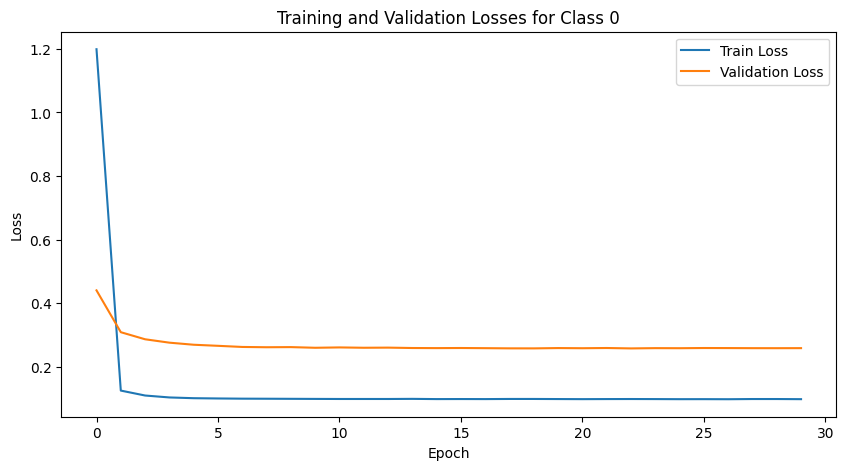

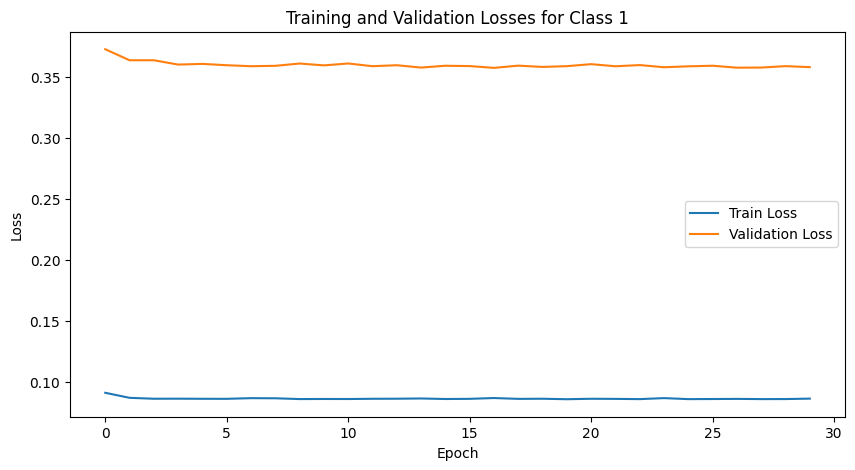

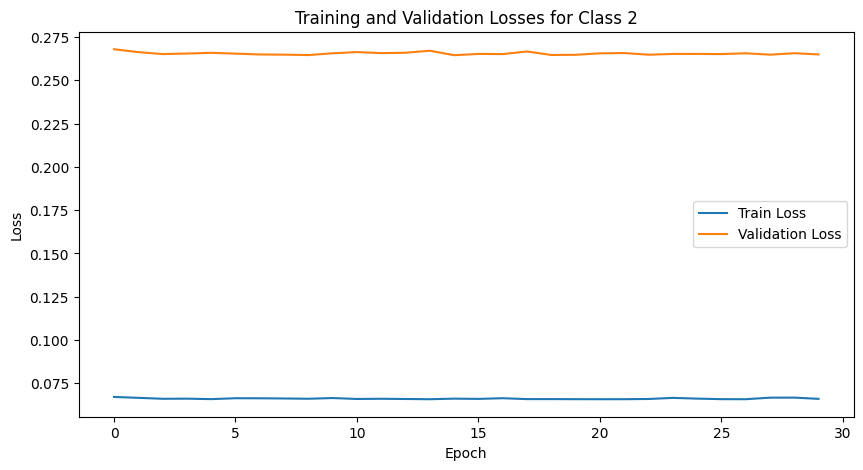

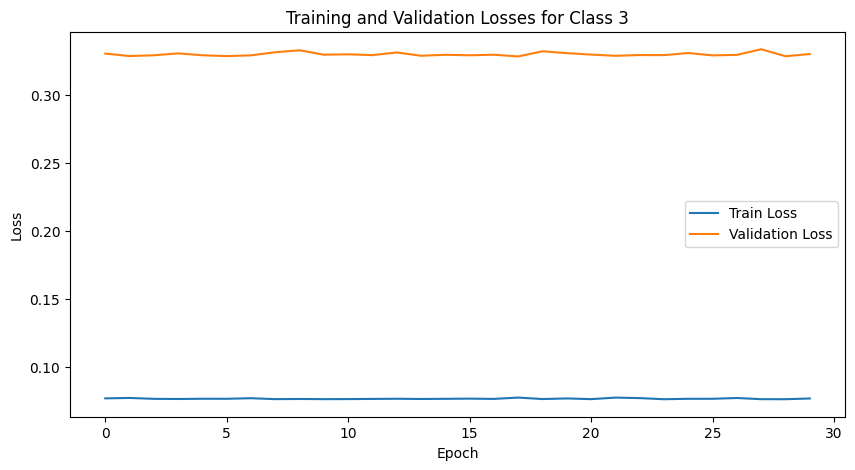

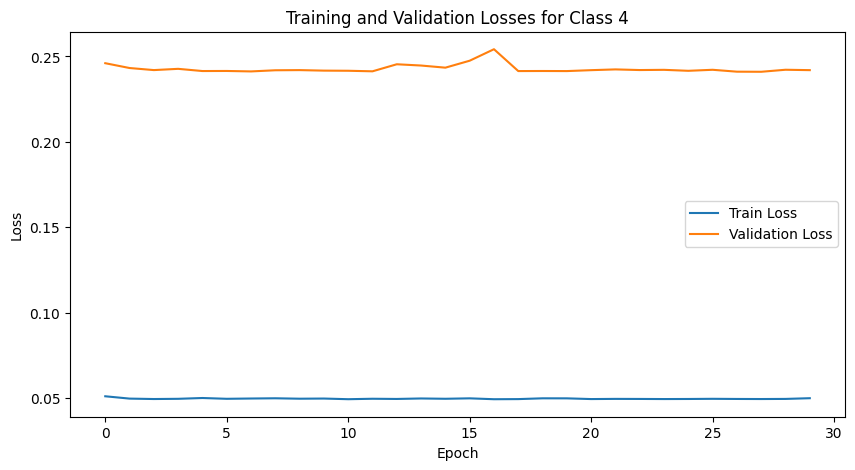

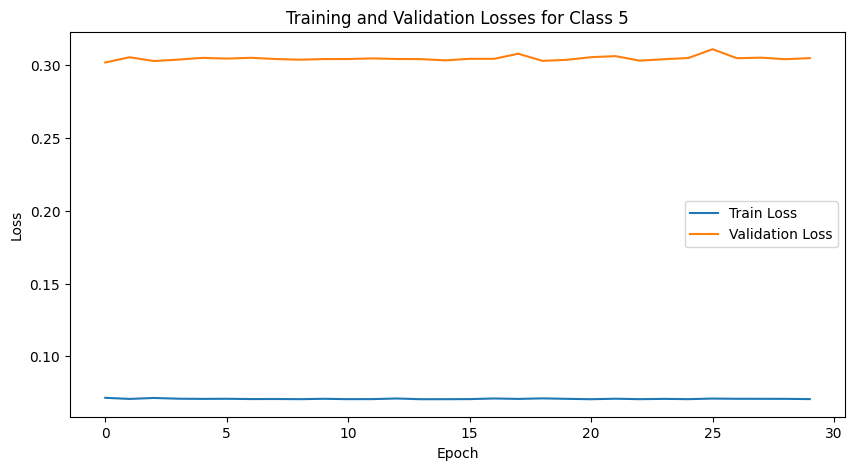

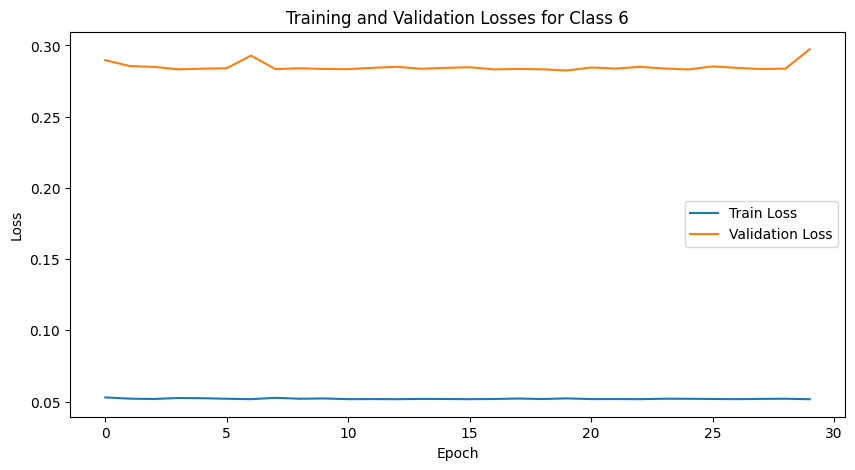

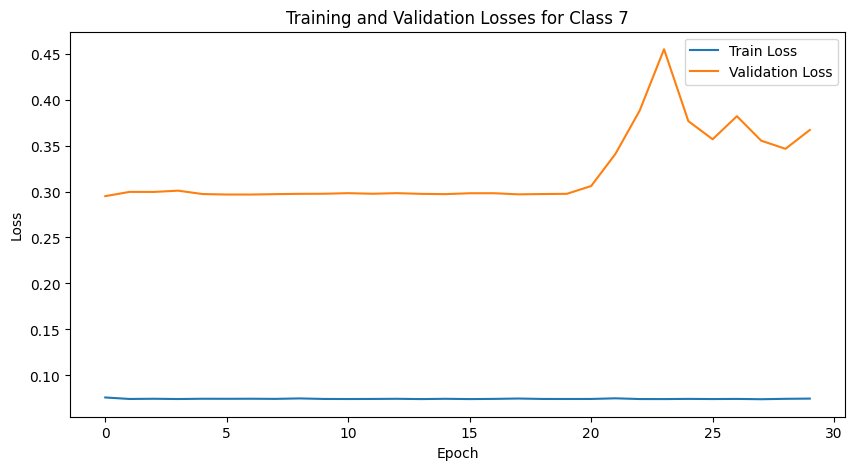

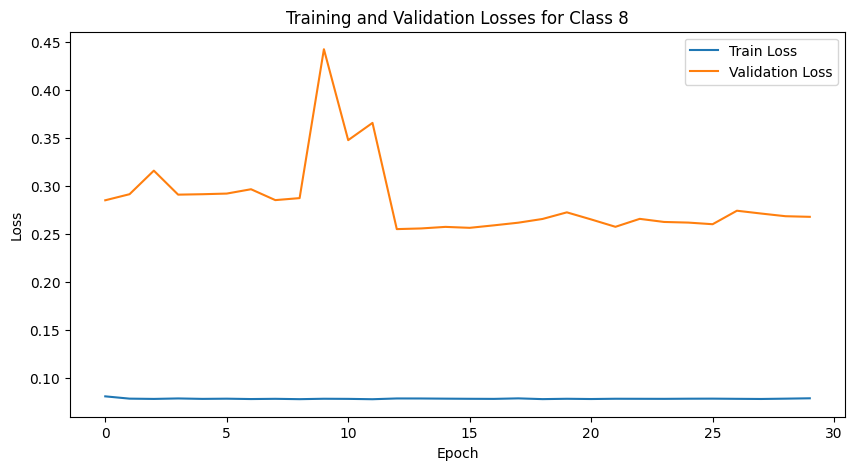

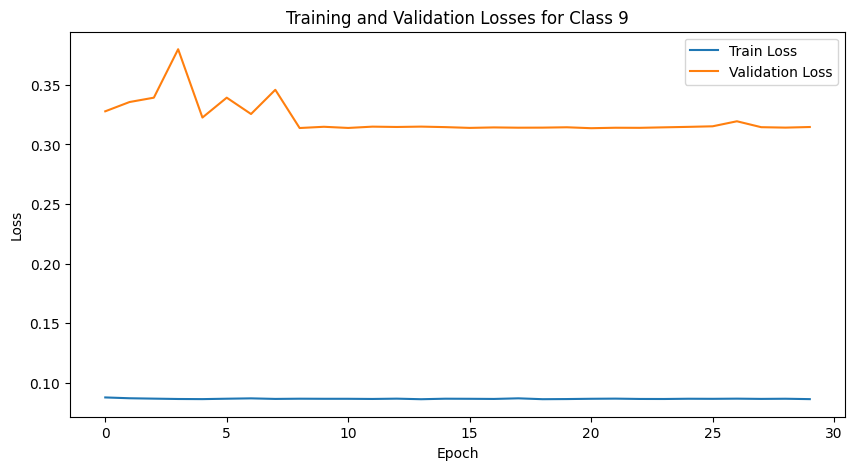

In [18]:
# Generate separate plots for losses after training
plot_losses_per_class_separately(all_train_losses, all_val_losses)

In [19]:
# Function to visualize the reconstruction of an image by the model
def visualize_reconstruction(vae, dataset, class_index):
    vae.eval()
    with torch.no_grad():
        # Select a random image from the dataset of the given class
        image, _ = dataset[np.random.randint(len(dataset))]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        reconstructed, _, _ = vae(image)

        # Convert tensors to numpy arrays for visualization
        original_image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5  # Denormalize
        reconstructed_image = reconstructed.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5  # Denormalize

        # Plot original and reconstructed images
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title(f'Original Image (Class {class_index})')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_image)
        plt.title(f'Reconstructed Image (Class {class_index})')
        plt.axis('off')

        plt.show()

Visualizing reconstruction for class 0...


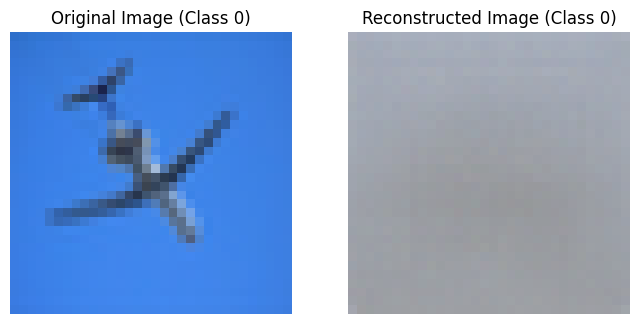

Visualizing reconstruction for class 1...


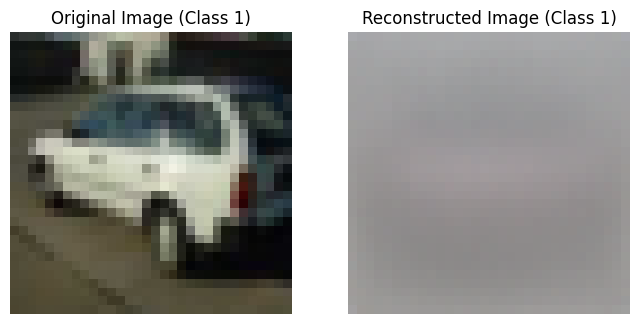

Visualizing reconstruction for class 2...


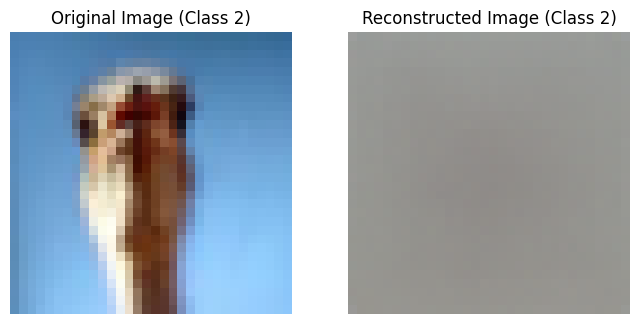

Visualizing reconstruction for class 3...


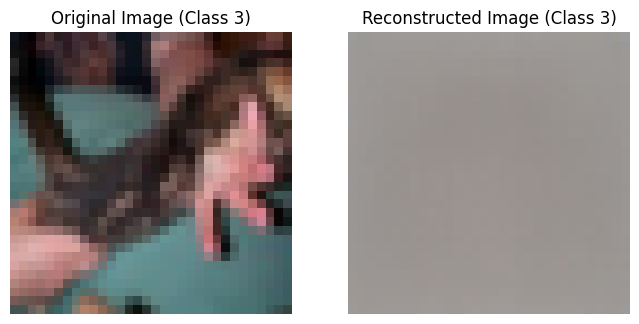

Visualizing reconstruction for class 4...


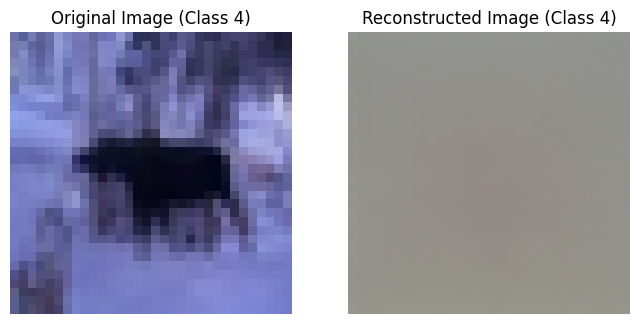

Visualizing reconstruction for class 5...


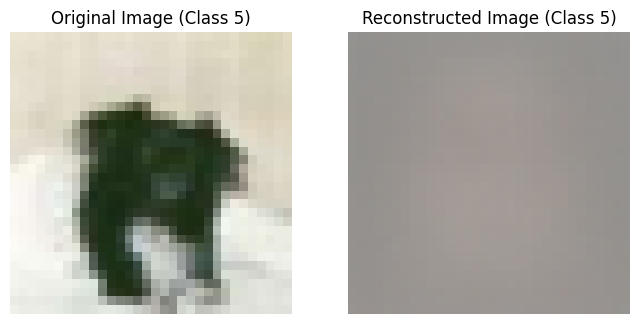

Visualizing reconstruction for class 6...


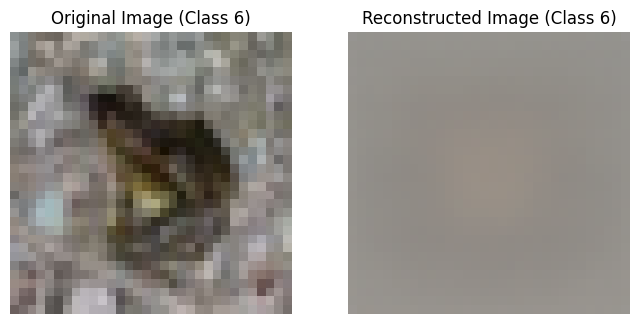

Visualizing reconstruction for class 7...


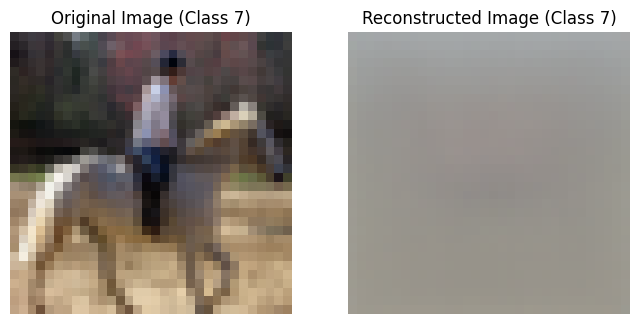

Visualizing reconstruction for class 8...


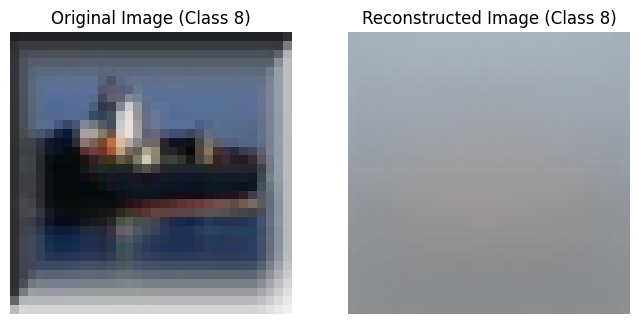

Visualizing reconstruction for class 9...


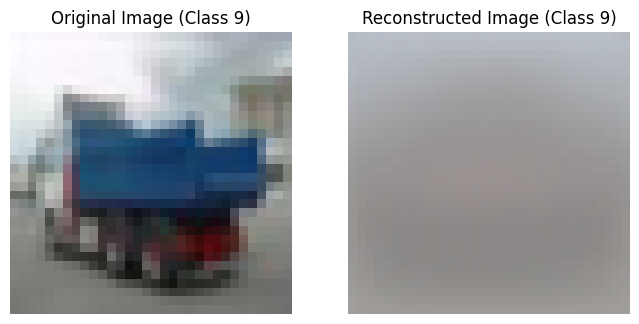

In [20]:
# Visualize reconstruction for each class
for class_index in range(10):
    print(f"Visualizing reconstruction for class {class_index}...")
    # Load the corresponding dataset and model for the class
    val_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=class_index, transform=transform, train=False, download=True)
    vae = VAE(latent_dim=128).to(device)
    vae.load_state_dict(torch.load(f'models/vae/vae_class_{class_index}_weights.pth'))
    visualize_reconstruction(vae, val_dataset, class_index)

## Generative Adversarial Network (GAN)

## Citation

```bibtex
@techreport{krizhevsky2009learning,
  title = {Learning Multiple Layers of Features from Tiny Images},
  author = {Alex Krizhevsky},
  institution = {University of Toronto},
  year = {2009},
  url = {https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf}
}